# Question 3

In [533]:
import wandb


In [534]:
import math

import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, utils
from sklearn.model_selection import train_test_split
from skimage import io,transform
from torchvision import datasets
from torchvision.transforms import ToTensor, ToPILImage, RandomCrop

%matplotlib inline
import matplotlib.pyplot as plt

In [535]:
df = pd.read_csv("deeplearning/train/labels.csv",header=None)

In [536]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
le = LabelEncoder()

In [537]:
def show_face(image, camera_position):
    """Show image with landmarks"""
    plt.title(camera_position)
    plt.imshow(image,cmap="gray")
    plt.pause(0.001)  # pause a bit so that plots are updated


In [538]:
def encode_dataframe(df):
    df[4] = df[1].astype(str) + "," + df[2].astype(str) +","+ df[3].astype(str)
    df[4]  = le.fit_transform(df[4])
    return df

In [539]:
class FaceDataset(Dataset):
    """Custom Fashion MNIST dataset."""

    def __init__(self, csv_file, image_dir,):
        self.labels_df = pd.read_csv(csv_file,header=None)
        self.labels_df = encode_dataframe(self.labels_df)
        self.transform = transform
        self.image_dir = image_dir

    def __len__(self):
        return len(self.labels_df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.image_dir,
                                self.labels_df.iloc[idx, 0])
        image = io.imread(img_name, as_gray=True)
        image = transform.resize(image,(160,160))
        convert_tensor = transforms.ToTensor()
        image = convert_tensor(image)
        image.unsqueeze(0)
        camera_position = torch.tensor(self.labels_df.iloc[idx, 4])
        camera_position =  camera_position.type(torch.LongTensor)





        return image.float(), camera_position,img_name

In [540]:
df2 = pd.read_csv("deeplearning/train/labels.csv",header=None)

In [541]:
encode_dataframe(df2).sort_values(by=4)

,0,1,2,3,4
249,0250.jpg,-0.087156,-0.996195,0.0,0
937,0938.jpg,-0.087156,-0.996195,0.0,0
1703,1704.jpg,-0.087156,-0.996195,0.0,0
313,0314.jpg,-0.087156,-0.996195,0.0,0
1127,1128.jpg,-0.087156,-0.996195,0.0,0
...,...,...,...,...,...
1518,1519.jpg,1.000000,0.000000,0.0,63
1070,1071.jpg,1.000000,0.000000,0.0,63
1134,1135.jpg,1.000000,0.000000,0.0,63
1582,1583.jpg,1.000000,0.000000,0.0,63


In [542]:
batch_size=32

In [543]:
train_dataset = FaceDataset(csv_file='deeplearning/train/labels.csv',
                           image_dir='deeplearning/train')

In [544]:
test_dataset = FaceDataset(csv_file='deeplearning/validate/labels.csv',
                            image_dir='deeplearning/validate')

In [545]:
train_split, validation_split = random_split(train_dataset,[1470,368])

In [546]:
train_dataloader = DataLoader(train_split, batch_size=batch_size,
                        shuffle=True, num_workers=0)

In [547]:
validation_dataloader = DataLoader(validation_split, batch_size=batch_size,
                                   shuffle=True, num_workers=0)

In [548]:
test_dataloader = DataLoader(test_dataset, batch_size=batch_size,
                              shuffle=False, num_workers=0)

In [570]:
def label_decode(label):
    temp = le.inverse_transform(label)
    temp = temp.reshape(1,-1).flatten()
    temp = temp[0].split(",")

    return np.array(temp).astype(float)

In [550]:
def angular_error(output,label):
    total_error  = 0
    for output_val,predic_val in zip(map(label_decode,[ [x] for x in output]),map(label_decode,[[x] for x in label])):
        total_error += torch.acos(torch.min(torch.tensor(1),torch.max(torch.tensor(-1),torch.dot(output_val,predic_val))))
    return torch.rad2deg(total_error)

In [551]:
# Solution

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.convlayers = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(6),
            nn.ReLU(),

            nn.MaxPool2d(kernel_size=2, stride=2), # B x 6 x 80 x 80 after this maxpool
            nn.Conv2d(in_channels=6, out_channels=12, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(12),
            nn.ReLU(),
            nn.Dropout(0.1),


            nn.MaxPool2d(kernel_size=2, stride=4), # B x 12 x20 x 20,
            nn.Conv2d(in_channels=12, out_channels=24, kernel_size=3, stride=1, padding=0),# B x 48 x 18x 18,
            nn.BatchNorm2d(24),
            nn.ReLU()



        )

        self.MLP = nn.Sequential(
            nn.Linear(in_features=24*18*18,out_features=120),
            nn.BatchNorm1d(120),
            nn.ReLU(),
            nn.Linear(in_features=120,out_features=84),
            nn.BatchNorm1d(84),
            nn.ReLU(),
            nn.Linear(in_features=84,out_features=64)
        )

    def forward(self, x):
        residual = x
        # Input x has dimensions B x 1 x 28 x 28, B is batch size
        x = self.convlayers(x)
        x = x.view(x.size(0), -1)
        x = self.MLP(x)
        # Output has dimensions B x 10
        return x

model = CNN()
model.to(device)
loss_func = nn.CrossEntropyLoss()

In [552]:
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(total_params)

952672


In [553]:
images,labels, _= next(iter(train_dataloader))

In [554]:
images[0].to(device).type()

'torch.cuda.FloatTensor'

In [555]:
labels.to(device).type()

'torch.cuda.LongTensor'

In [556]:
labels =  labels.type(torch.LongTensor)
output = model(images.to(device).float())
print(output.shape)
loss = loss_func(output.to(device),labels.to(device))
print(loss)

torch.Size([32, 64])
tensor(4.1920, device='cuda:0', grad_fn=<NllLossBackward0>)


In [557]:
num_epochs = 25
learning_rate =0.01

In [558]:
wandb.init(project="int3", entity="samk", config=
{"learning_rate": learning_rate,
    "epochs": num_epochs,
    "batch_size": batch_size
})
wandb.watch(model, log="all",log_freq=10,)

[]

In [559]:


# Set up the optimiser
optim = torch.optim.Adam(model.parameters(), lr = learning_rate)

# Initialise some variables for computing and tracking stats
iterations_per_epoch = math.ceil(len(train_dataset)/batch_size)
training_losses = []
training_accuracies = []
validation_losses = []
validation_accuracies = []
for epoch in range(num_epochs):

    # One epoch on the training set
    total_loss = 0
    correct = 0
    total = 0
    total_loss = 0
    angle_error = 0
    for i, (inputs, labels,_) in enumerate(train_dataloader):
        inputs, labels = inputs.to(device), labels.to(device)
        output = model(inputs)
        loss = loss_func(output,labels)
        optim.zero_grad()
        loss.backward()
        optim.step()
        pred_y = torch.argmax(output, 1)
        angle_error += angular_error(pred_y.to("cpu"),labels.to("cpu"))
        correct += (pred_y == labels).sum()
        total += float(labels.size(0))
        total_loss += loss*images.shape[0]
        if (i+1) % 100 == 0:
            print('Epoch [{}/{}], Iteration [{}/{}], Loss: {:.4f}'.format(epoch + 1, num_epochs, i + 1, iterations_per_epoch, loss.item()))
    total_loss /= len(train_dataset)
    training_losses.append(total_loss.item())
    training_accuracies.append(correct/total)
    wandb.log({"epoch" : epoch+1 , "train_accuracy":training_accuracies[-1]})
    print('Train accuracy over epoch {}: {:.4f}'.format(epoch+1,training_accuracies[-1]))
    print(f"Mean Angular Error ={angle_error/len(train_dataset)}")

    # One epoch on the validation set
    correct = 0
    total = 0
    # Switch to evaluation mode
    model.eval()
    with torch.no_grad():
        for inputs, labels,_ in validation_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            output = model(inputs)
            loss = loss_func(output,labels)
            pred_y = torch.argmax(output, 1)
            correct += (pred_y == labels).sum()
            total += float(labels.size(0))
            total_loss += loss*images.shape[0]
        validation_accuracy = correct/total
    total_loss /= len(validation_split)
    validation_losses.append(total_loss.item())
    # Switch back to training mode
    model.train()
    validation_accuracies.append(validation_accuracy)
    wandb.log({"epoch" : epoch+1 , "test_accuracy":validation_accuracy})
    print('Test accuracy at epoch {}: {:.4f}'.format(epoch+1,validation_accuracy))

Train accuracy over epoch 1: 0.2279
Mean Angular Error =20.430156850628048
Test accuracy at epoch 1: 0.4429
Train accuracy over epoch 2: 0.5211
Mean Angular Error =9.012123584484387
Test accuracy at epoch 2: 0.5897
Train accuracy over epoch 3: 0.6524
Mean Angular Error =6.168474028958667
Test accuracy at epoch 3: 0.6739
Train accuracy over epoch 4: 0.7088
Mean Angular Error =4.867398488762656
Test accuracy at epoch 4: 0.7799
Train accuracy over epoch 5: 0.7701
Mean Angular Error =3.8418080986772303
Test accuracy at epoch 5: 0.8125
Train accuracy over epoch 6: 0.8129
Mean Angular Error =3.075981364629618
Test accuracy at epoch 6: 0.8804
Train accuracy over epoch 7: 0.8714
Mean Angular Error =2.208560481612105
Test accuracy at epoch 7: 0.8424
Train accuracy over epoch 8: 0.9020
Mean Angular Error =1.8005725815936415
Test accuracy at epoch 8: 0.8641
Train accuracy over epoch 9: 0.8884
Mean Angular Error =1.961472341306189
Test accuracy at epoch 9: 0.8859
Train accuracy over epoch 10: 0.86

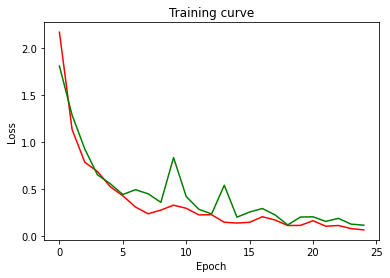

In [560]:
plt.title("Training curve")
plt.plot(range(len(training_losses)),training_losses,'r')
plt.plot(range(len(validation_losses)),validation_losses,'g')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()


In [642]:
!wget https://www-users.york.ac.uk/~sk1438/model_weights.pth

'wget' is not recognized as an internal or external command,
operable program or batch file.


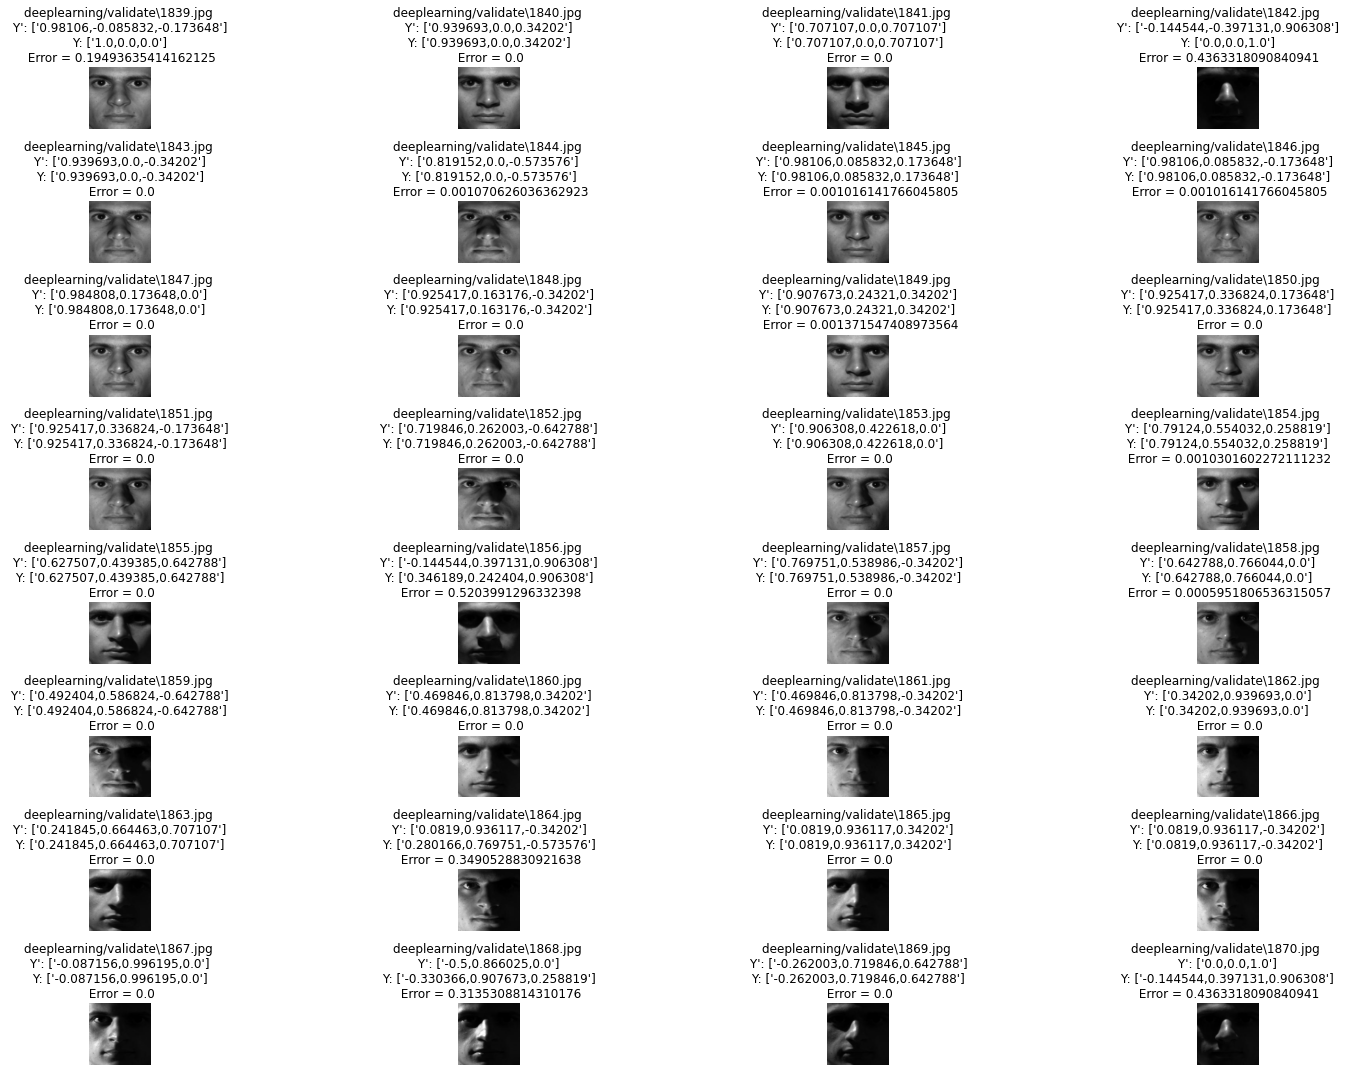

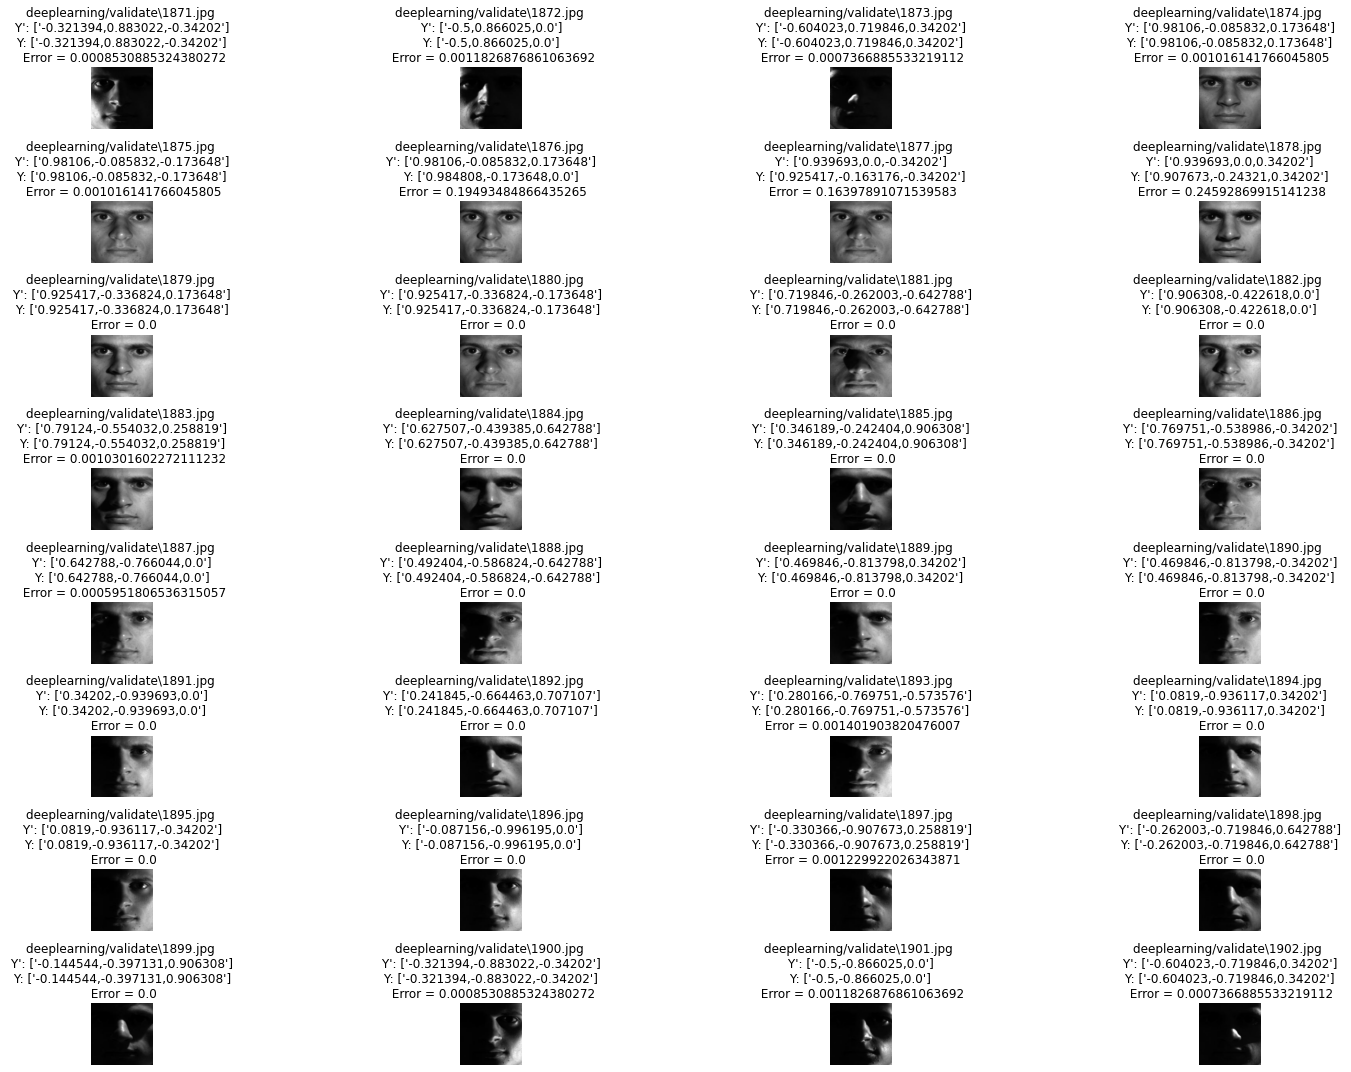

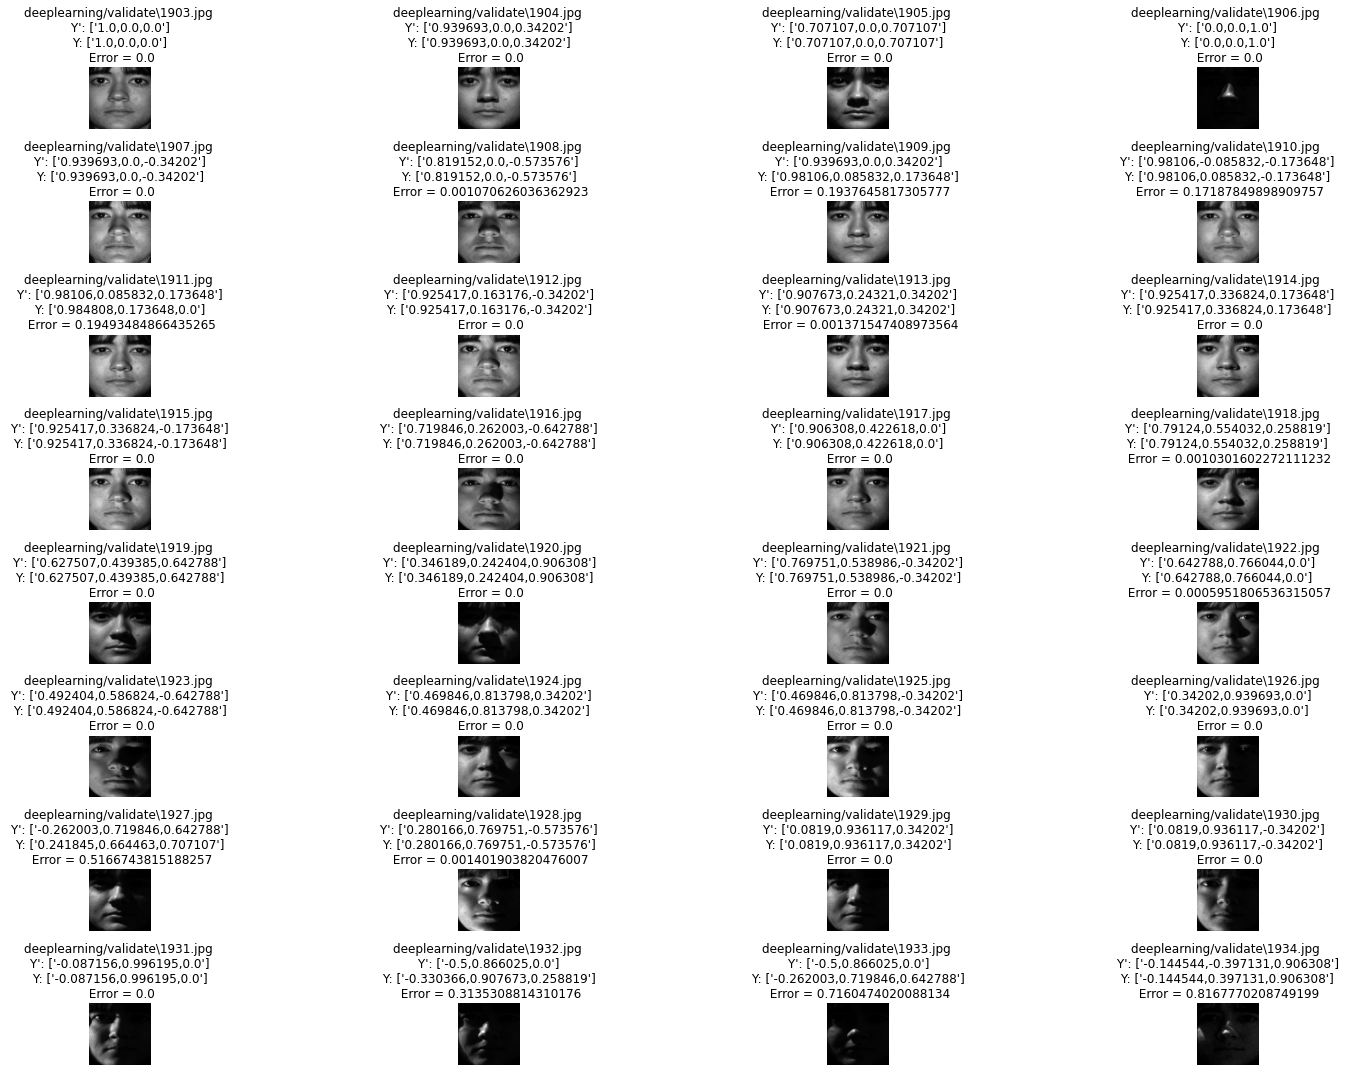

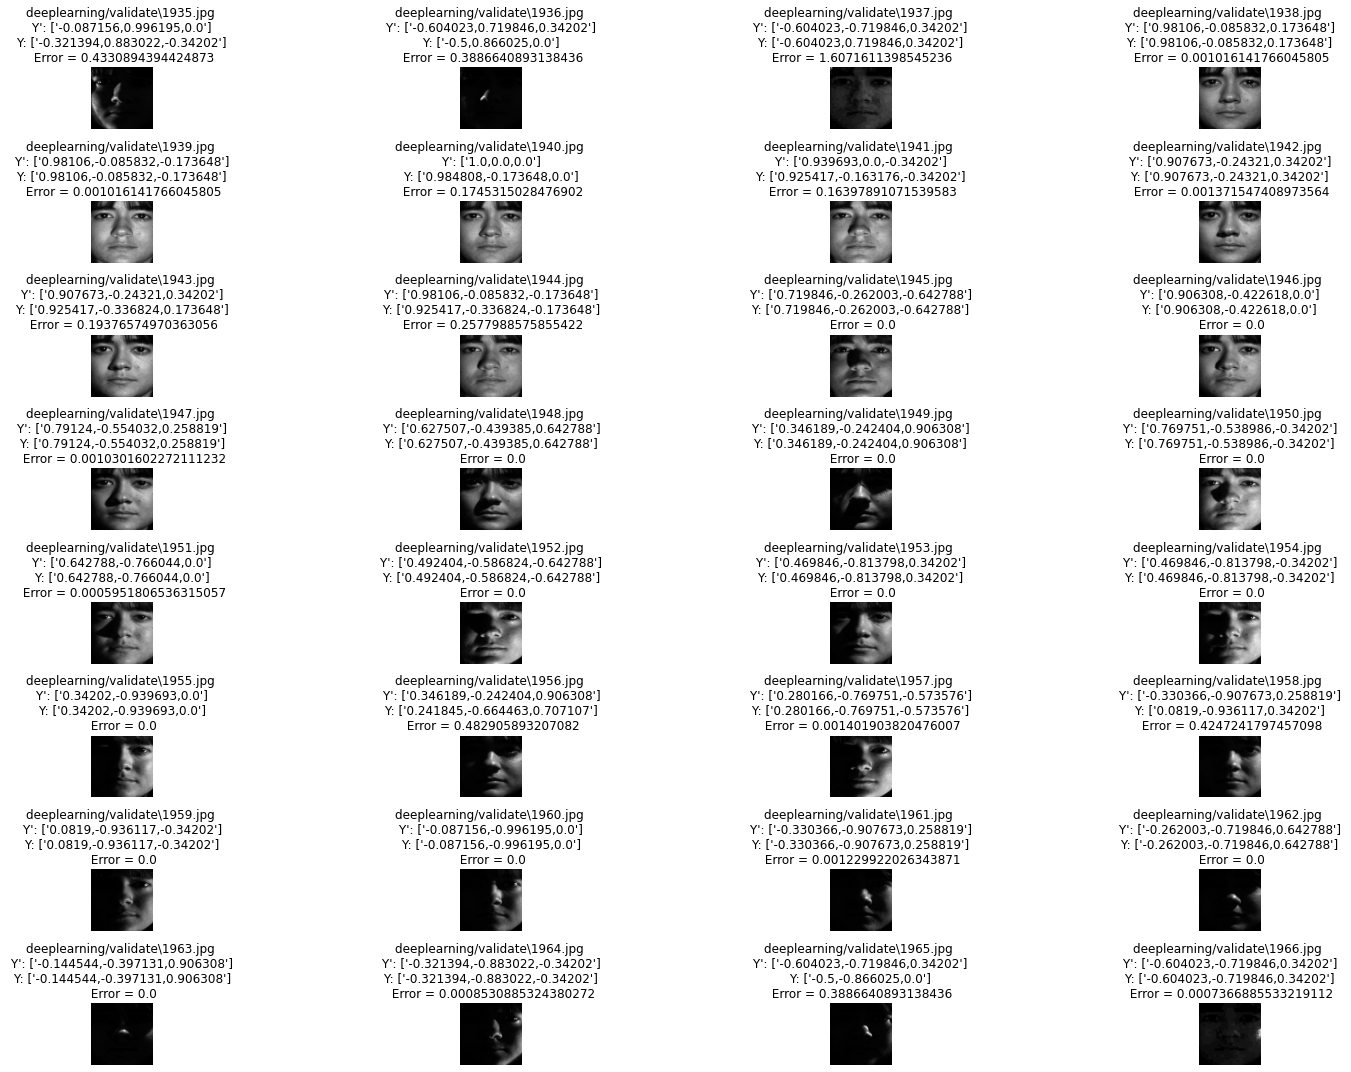

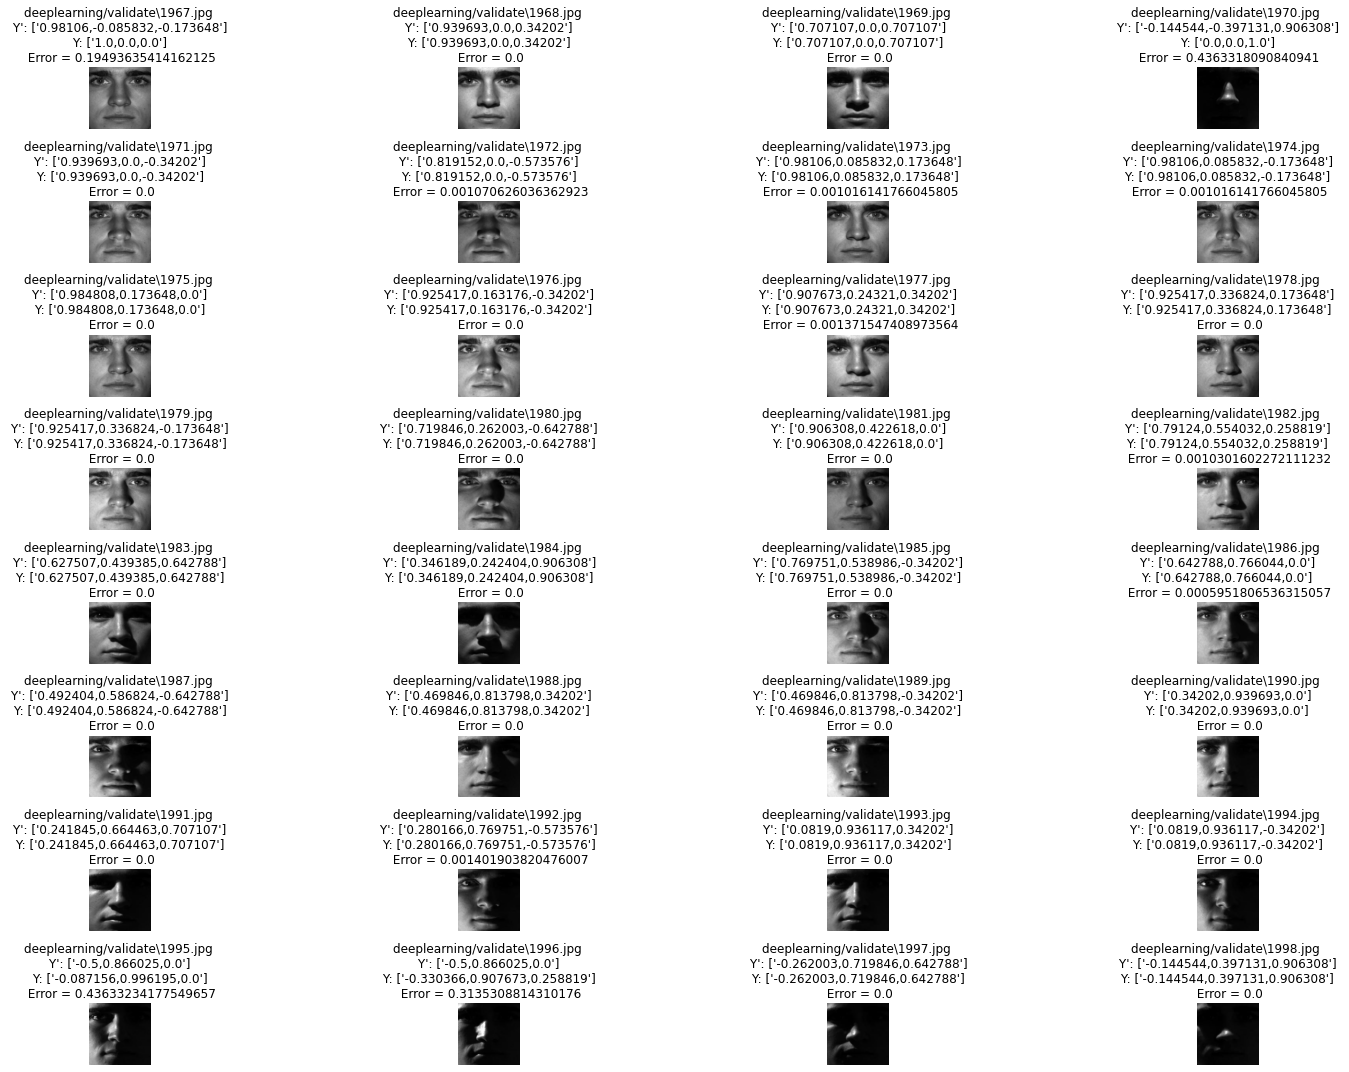

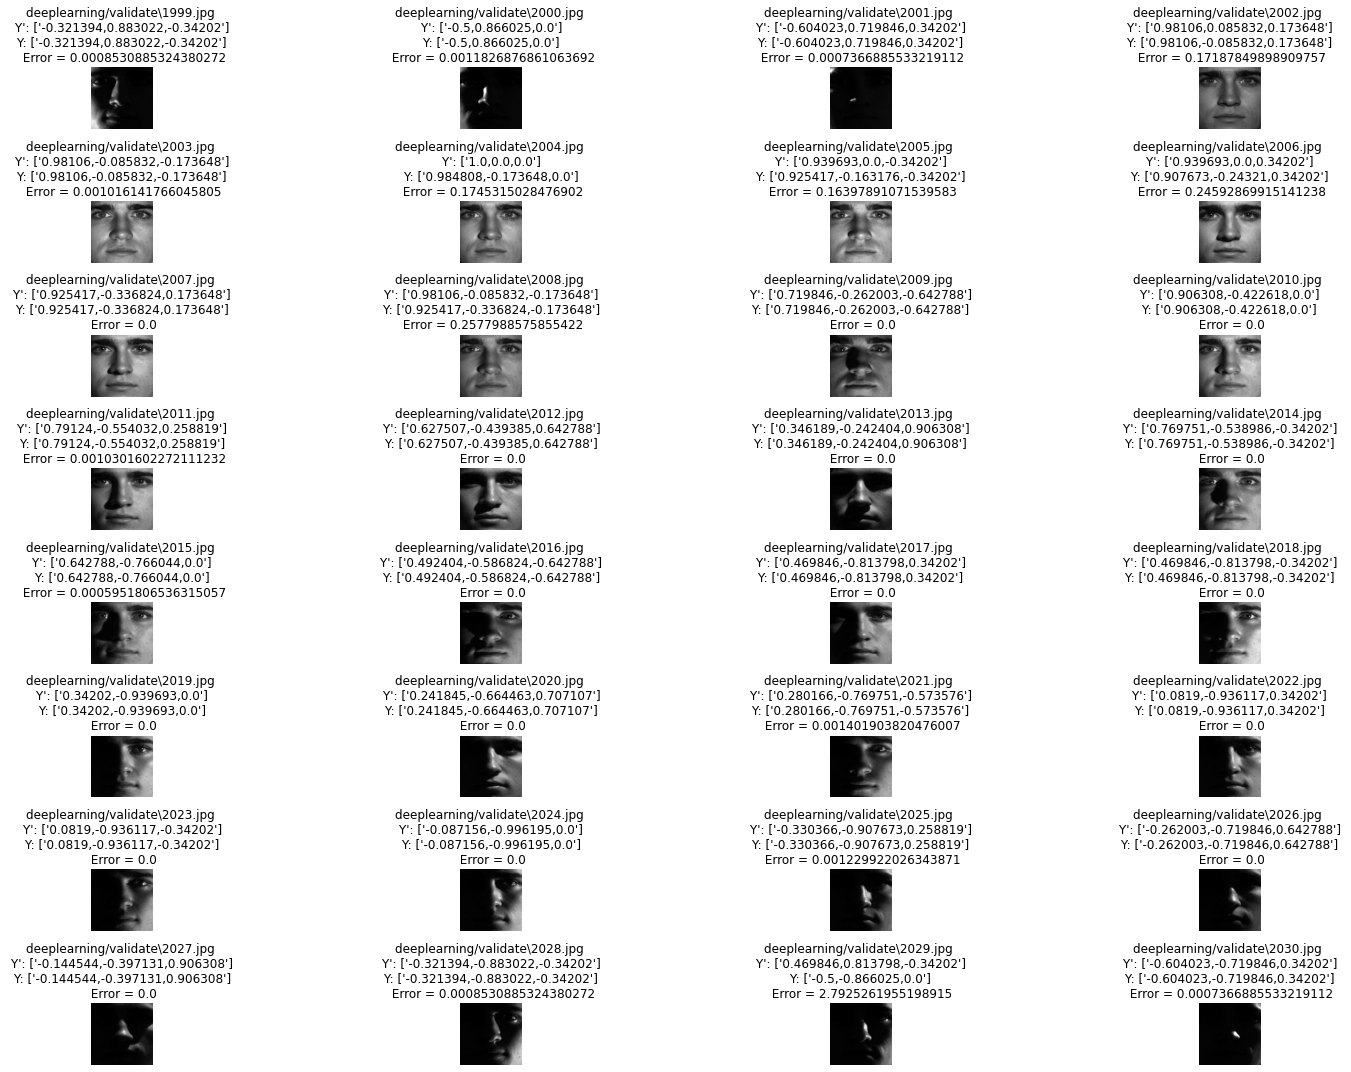

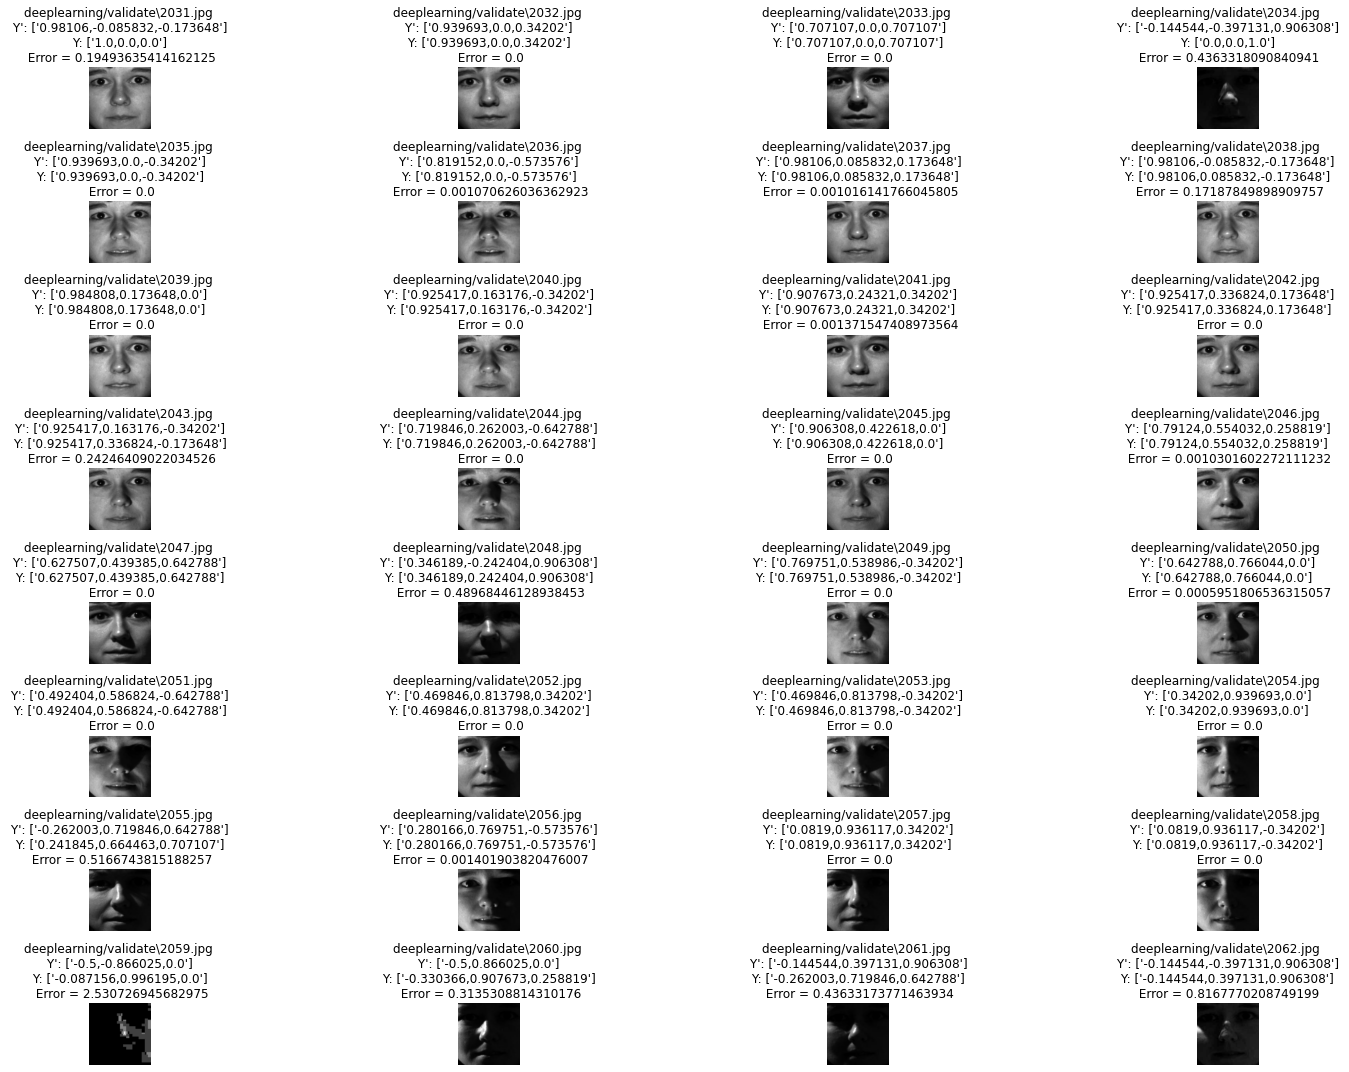

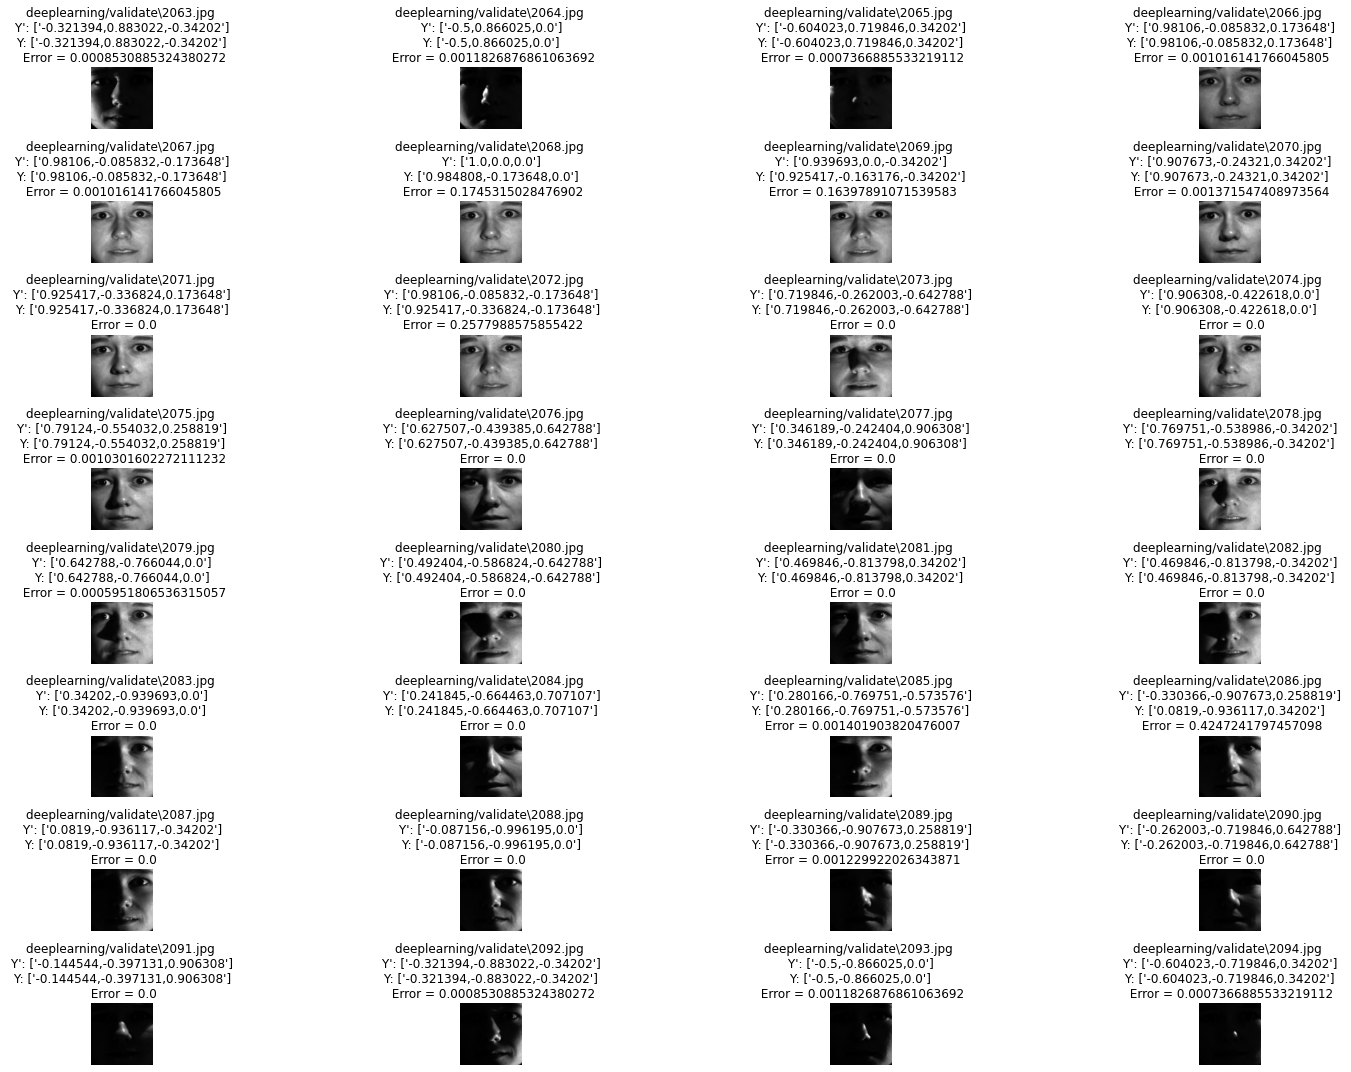

 Mean Angle Error is :0.09


In [630]:
angle_errors = []
for index, (images, labels,image_names) in enumerate(test_dataloader):
    images,labels = images.to(device), labels.to(device)
    output = model(images)
    pred_y = torch.argmax(output, 1)
    # Display first 25 images with predicted labels
    figure = plt.figure(figsize=(30, 15))
    for i in range(32):
        figure.add_subplot(8, 4, i+1)
        error = torch.acos(torch.min(torch.tensor(1),torch.max(torch.tensor(-1),torch.dot(label_decode([pred_y[i].item()]),label_decode([labels[i].item()])))))
        angle_errors.append(error)
        plt.title(f"{image_names[i]} \n Y': {le.inverse_transform([pred_y[i].item()])} \n Y: {le.inverse_transform([labels[i].item()])} \n Error = {error}")
        plt.axis("off")
        plt.imshow(images[i,:].squeeze().cpu(), cmap="gray")
    figure.tight_layout()
    plt.tight_layout()
    plt.show()
error = sum(angle_errors)/len(angle_errors)
error = np.asarray(error)
print(f" Mean Angle Error is :{np.round(error,2)}")
